In [1]:
import tensorflow as tf
import os
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline


In [2]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.applications import inception_resnet_v2
#from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop

from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense
from keras import regularizers
from keras import initializers

In [3]:
path = '/home/jgomez/Documents/Us'

In [4]:
train_dir = path + "/train"
test_dir = path + "/val"

In [5]:
datagen_train = ImageDataGenerator(
    rescale=1./255,
      rotation_range=180,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=[0.9, 1.5],
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')

In [6]:

def create_model():
    
    def add_conv_block(model, num_filters):
        
        model.add(Conv2D(num_filters, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(l = 0.01), kernel_initializer = 'he_normal' ))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Conv2D(num_filters, 3, activation='relu', padding='valid', kernel_regularizer=regularizers.l2(l = 0.01), kernel_initializer = 'he_normal'))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Conv2D(num_filters, 3, activation='relu', padding='valid', kernel_regularizer=regularizers.l2(l = 0.01), kernel_initializer = 'he_normal'))
        model.add(BatchNormalization())
        model.add(Conv2D(num_filters, 3, activation='relu', padding='valid', kernel_regularizer=regularizers.l2(l = 0.01), kernel_initializer = 'he_normal'))
        model.add(BatchNormalization())
        model.add(Conv2D(num_filters, 3, activation='relu', padding='valid', kernel_regularizer=regularizers.l2(l = 0.01), kernel_initializer = 'he_normal'))
        model.add(MaxPooling2D(pool_size=2))
        model.add(BatchNormalization())

        return model
    
    model = tf.keras.models.Sequential()
    model.add(Input(shape=(224, 224, 3)))
    
    model = add_conv_block(model, 32)
    model.add(Flatten())
    model.add(Dense(2))
    model.add(Dense(2, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 110, 110, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 53, 53, 32)        9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 53, 53, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 51, 51, 32)        9

In [7]:
batch_size = 32

In [8]:
input_shape = model.layers[0].output_shape[1:3]
input_shape

(224, 224)

In [9]:
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    shuffle=True)

Found 45646 images belonging to 2 classes.


In [10]:
datagen_test = ImageDataGenerator(rescale=1./255)

In [11]:
generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)

Found 1194 images belonging to 2 classes.


In [12]:
h = model.fit(
    generator_train,
    validation_data=generator_test,
    epochs=50, 
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15),
        tf.keras.callbacks.ModelCheckpoint('models/model_{val_accuracy:.3f}.h5', save_best_only=True,
                                          save_weights_only=False, monitor='val_accuracy')
    ]
)

Epoch 1/50
1427/1427 [==============================] - 1100s 771ms/step - loss: 1.6884 - accuracy: 0.5135 - val_loss: 0.8025 - val_accuracy: 0.5025
Epoch 2/50
1427/1427 [==============================] - 1085s 761ms/step - loss: 0.7214 - accuracy: 0.5148 - val_loss: 0.6959 - val_accuracy: 0.5000
Epoch 3/50
1427/1427 [==============================] - 1082s 758ms/step - loss: 0.6937 - accuracy: 0.4997 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/50
1427/1427 [==============================] - 1075s 753ms/step - loss: 0.6932 - accuracy: 0.4950 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/50
1427/1427 [==============================] - 1073s 752ms/step - loss: 0.6932 - accuracy: 0.4968 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/50
1427/1427 [==============================] - 1072s 751ms/step - loss: 0.6932 - accuracy: 0.4985 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/50
1427/1427 [==============================] - 1077s 755ms/step - loss: 0.6932 - accuracy: 0.4989

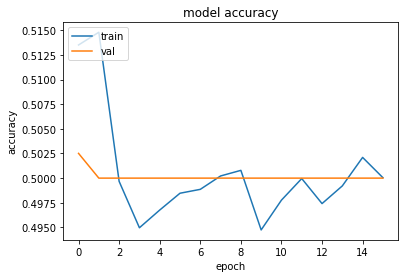

In [14]:
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()